In [1]:
from unsloth import FastLanguageModel
import torch

max_seq_length = 2048
dtype = None
load_in_4bit = False

#model_name = "deepseek-r1-distill-llama-8b-unsloth-bnb-4bit-rule-extractor-v2-rule-extractor-v3-continue"
#model_name = "istral-Small-24B-Instruct-2501-unsloth-bnb-4bit-rule-extractor-v2all" #istral-Small-24B via GT
#model_name = "DeepSeek-R1-Distill-Qwen-14B-unsloth-bnb-4bit"
#model_name = "istral-Small-24B-Instruct-2501-unsloth-bnb-4bit" #istral-Small-24B base
#model_name = "istral-Small-24B-Instruct-2501-unsloth-bnb-4bit-rule-extractor-v2all-rule-extractor-v3-continue"
model_name = "istral-Small-24B-Instruct-2501-unsloth-bnb-4bit-rule-extractor-v2all-rule-extractor-v3-continue-e15"
#model_name = "DeepSeek-R1-Distill-Qwen-14B-unsloth-bnb-4bit-rule-extractor-v2-rule-extractor-v3-continue-e20"
#model_name = "DeepSeek-R1-Distill-Qwen-14B-unsloth-bnb-4bit-rule-extractor-v2-rule-extractor-v3-continue"
#model_name = "istral-Small-24B-Instruct-2501-unsloth-bnb-4bit-rule-extractor-v2-rule-extractor-v3-continue"
#model_name = "deepseek-r1-distill-llama-8b-unsloth-bnb-4bit-rule-extractor-v2-rule-extractor-v3-continue-e12"
inputfile = "NSFTdatasetv3_na_test_data.json"
outputfile = model_name+'_extracted_rules_gtd.json'

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit
  )

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.19: Fast Mistral patching. Transformers: 4.50.3.
   \\   /|    NVIDIA vGPU-32GB. Num GPUs = 1. Max memory: 31.503 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Unsloth 2025.3.19 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.


In [2]:
!nvidia-smi

Mon Apr 21 12:06:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA vGPU-32GB               On  |   00000000:65:00.0 Off |                  N/A |
| 65%   43C    P2            170W /  320W |   30834MiB /  32760MiB |     45%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import json
import re
def generate_rules(input_text):
    _instruction = '''从给定的法律条文中抽取规则（可能是一条或者多条规则），并结构化存储。每条规则应包括以下字段：
- rule_id：由规则的出处自动生成，如果规则文本可拆解出多条规则，则用_num 进行编号,例如“《中华人民共和国刑法》第二条_1”。
- subject：规则的主体，指负责执行或管理该规则的机构或个人。
- object：规则的对象，指受规则约束的机构或个人。
- test：规则的触发条件，描述对象需要满足的条件。
- consequence：规则的后果，描述对象在满足 test 条件后可能面临的措施或处罚。
- rule_type：5种规则类型，'义务性规则'、'禁止性规则'、'授权性规则'、'原则性规则'、'鼓励性规则'，如果不在5种之一设为 '其他'”。
- reference：规则的出处，例如具体的法律法规条款,例如"《中华人民共和国刑法(2023修正)》第一编　总则 第一章　刑法的任务、基本原则和适用范围 第二条"。
- depend_on：若该规则依赖于其他规则，则列出依赖规则的 rule_id，否则设为 'null'。
- tag：法条的简单总结性描述，在原文中可能使用【】符合标识，也可能没有，需要根据法条内容总结。
对于所有字段，如果从规则文本中提取不出内容，则填写null。规则的主体和对象不同时为空。
'''
    prompt = f"""请严格按JSON格式从input (法律条文)中提取法律规则:

### input (法律条文)：
{input_text}
### Instruction（当前任务）：
{_instruction}

### Response (按JSON格式生成抽取结果，一个列表):
"""
    #print('prompt is:')
    #print(prompt)

    FastLanguageModel.for_inference(model)  # Unsloth has 2x faster inference!
    #inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    """
    from transformers import TextStreamer
    text_streamer = TextStreamer(tokenizer)
    outputs = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 2048)
    full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    #print(full_response)
    """
    inputs = tokenizer(prompt, 
                       return_tensors="pt",
                       return_attention_mask=True # 关键参数
                      ).to(model.device)
    outputs = model.generate(
        inputs.input_ids,
        max_new_tokens=max_seq_length,
        temperature=0.1,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id,
        attention_mask=inputs.attention_mask  # 传递attention_mask
    )
    
    full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    #print('full_response:')
    #print(full_response)
    
    # 后处理流程
    try:
        # 提取JSON数组部分
        '''
        full_response = re.split(r'"rules":', full_response, flags=re.IGNORECASE)[-1]
        json_str = re.search(r'\[.*\]', full_response, re.DOTALL).group()
        '''
        pattern = re.compile(r'\s*((?:\[).*?(?:\})\n(?:\]))\s*', re.DOTALL)
        #pattern = re.compile(r'\[\n  \{.*\}\n]', re.DOTALL)
        #pattern = re.compile(r'\s*((?:\[).*(?:\]))\s*', re.DOTALL)
       
        #resultlist =list(pattern.findall(full_response.split("### Response:")[-1]))
        resultlist =list(pattern.findall(full_response.split(" </think>")[-1]))
        print(resultlist)
        json_str = resultlist[-1]
        
        
        json_str = json_str.replace("，", ",").replace("：", ":")  # 统一符号
        
        # 转换并验证结构
        data = json.loads(json_str)
        if not isinstance(data, list):
            raise ValueError("顶层结构不是数组")
            
        required_fields = ["rule_id", "subject", "object", "test", 
                         "consequence", "rule_type", "reference", "depend_on","tag"]
        for item in data:
            if not all(field in item for field in required_fields):
                missing = [f for f in required_fields if f not in item]
                raise ValueError(f"缺失字段：{missing}")
                
        return data
        
    except Exception as e:
        print(f"解析失败：{str(e)}")
        print("原始响应：\n", full_response)
        return None

In [4]:
# 加载示例数据
with open(inputfile) as f:
    examples = json.load(f)

In [5]:
def validate_rule(rule):
    """验证单个规则的完整性"""
    errors = []
    
    # 字段存在性检查
    required_fields = ["rule_id", "subject", "object", "test", 
                      "consequence", "rule_type", "reference", "depend_on"]
    for field in required_fields:
        if field not in rule:
            errors.append(f"缺失字段：{field}")
    
    # ID格式验证（示例：医保条例_第三十八条_1）
    if not re.match(r".+?_\d+", rule.get("rule_id", "")):
        errors.append("rule_id格式错误")
    
    # 规则类型验证 
    valid_types = {"义务性规则", "禁止性规则", "授权性规则", 
                 "原则性规则", "鼓励性规则", "其他"}
    if rule.get("rule_type") not in valid_types:
        errors.append(f"无效类型：{rule.get('rule_type')}")
    
    # 依赖关系验证
    depend_on = rule.get("depend_on")
    if depend_on != "null" and depend_on:
        errors.append("depend_on应为列表或null")
    
    return {
        "is_valid": len(errors) == 0,
        "errors": errors,
        "rule_id": rule.get("rule_id", "未知ID")
    }

In [6]:
# %% [markdown]
# ### 5.2 生成规则结果

# %%
all_rules = []
groundtruth = []
for example in examples:
    print("正在生成规则...")
    rules = generate_rules(example["original"]["text"])
    groundtruth.append(example["groundtruth"])
    #break

    if rules:
        print("成功生成规则：")
        rules_json = json.dumps(rules, indent=2, ensure_ascii=False)
        #print(rules_json)
        # 执行验证
        print("\n验证结果：")
        for rule in rules:
            result = validate_rule(rule)
            status = "✓" if result["is_valid"] else "✗"
            print(f"{status} {result['rule_id']}")
            if not result["is_valid"]:
                print("   错误列表：")
                for err in result["errors"]:
                    print(f"   - {err}")
    else:
        print("规则生成失败")
        rules = []
    all_rules.append(rules)
#print(all_rules)

正在生成规则...
['[\n  {\n    "consequence": "只适用于罪行极其严重的犯罪分子",\n    "depend_on": "null",\n    "object": "死刑",\n    "reference": "《中华人民共和国刑法(2023修正)》第一编\u3000总则 第三章\u3000刑罚 第四十八条",\n    "rule_id": "《中华人民共和国刑法》第四十八条_1",\n    "rule_type": "原则性规则",\n    "subject": "null",\n    "tag": "死刑、死缓的适用对象及核准程序",\n    "test": "null"\n  },\n  {\n    "consequence": "如果不是必须立即执行的，可以判处死刑同时宣告缓期二年执行",\n    "depend_on": "null",\n    "object": "犯罪分子",\n    "reference": "《中华人民共和国刑法(2023修正)》第一编\u3000总则 第三章\u3000刑罚 第四十八条",\n    "rule_id": "《中华人民共和国刑法》第四十八条_2",\n    "rule_type": "原则性规则",\n    "subject": "null",\n    "tag": "死刑、死缓的适用对象及核准程序",\n    "test": "应当判处死刑的"\n  },\n  {\n    "consequence": "死刑除依法由最高人民法院判决的以外，都应当报请最高人民法院核准",\n    "depend_on": "null",\n    "object": "死刑",\n    "reference": "《中华人民共和国刑法(2023修正)》第一编\u3000总则 第三章\u3000刑罚 第四十八条",\n    "rule_id": "《中华人民共和国刑法》第四十八条_3",\n    "rule_type": "原则性规则",\n    "subject": "null",\n    "tag": "死刑、死缓的适用对象及核准程序",\n    "test": "null"\n  },\n  {\n    "consequence": "可以由高级

In [7]:
#filepath = 'extracted_rules.json'
try:
    # 写入文件（确保中文正常显示）
    with open(outputfile, 'w', encoding='utf-8') as f:
        json.dump(all_rules, f, 
                  ensure_ascii=False,  # 禁用ASCII转义
                  indent=2)
            
        print(f"成功保存{len(all_rules)}条规则到：{outputfile}")  
except Exception as e:
        print(f"保存失败：{str(e)}")

成功保存11条规则到：istral-Small-24B-Instruct-2501-unsloth-bnb-4bit-rule-extractor-v2all-rule-extractor-v3-continue-e15_extracted_rules_gtd.json


_pred_rules is 《中华人民共和国刑法》第二百零二条_1
_gt_rules is 《中华人民共和国刑法》第八十六条_1
_pred_rules is 《医保基金管理使用条例》第七条_1
_gt_rules is 《医疗保障基金使用监督管理条例》第七条_1
_pred_rules is 《中华人民共和国刑法》第四百五十条_1
_gt_rules is 《中华人民共和国刑法》第四百五十条


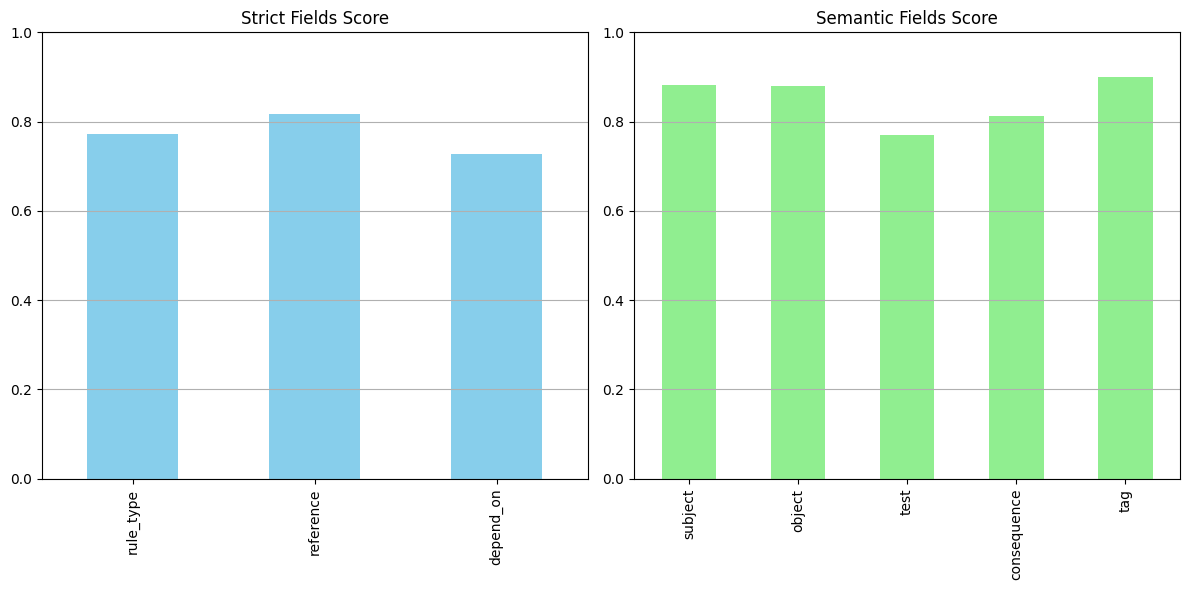

规则级评估报告：
规则数量一致性=72.73%
规则ID一致性=86.36%
字段级评估报告：

严格字段准确率：


,Field,Accuracy
0,rule_type,0.772727
1,reference,0.818182
2,depend_on,0.727273



语义字段平均分：


,Field,Score
0,subject,0.881818
1,object,0.879091
2,test,0.770909
3,consequence,0.811818
4,tag,0.900455



总体统计：
严格字段平均准确率：77.27%
语义字段平均得分：84.88%
所有字段平均得分：81.53%
评估报告已保存至：istral-Small-24B-Instruct-2501-unsloth-bnb-4bit-rule-extractor-v2all-rule-extractor-v3-continue-e15_extracted_rules_gtd_evaluation_report.md


In [8]:
# 示例用法：
from score import Score
scorer = Score(pred_data=all_rules, gt_data=groundtruth,pred_json_path=outputfile)
scorer.calc_score()